# Lecture

Video: https://www.youtube.com/watch?v=P6sfmUTpUmc


Below is my attempt to follow along with the lecture


Learnings on weight initialization for more efficient training
- If the h *w2 = logits, and we softmax(logits) to get our probability distribution, and we nll(softmax(logits)) to get our loss.  If w2 is semi-large, then we could end up getting logits like [3, 3, 30].  This doesn't make much sense, especially at initialization since our weights aren't trained.  Therefore, to reduce our initial loss, we can scale W2 down, which will make the logits smaller, making our Pr distribution smoother, and the loss smaller.  This will get rid of the 'hockey stick' style graphs that we see since the network no longer needs to squash down the logits before tuning them correctly.  This helps train our network more efficiently.


In [86]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [3]:
import random

names = open('names.txt', 'r').read().splitlines()
num_names = len(names)

# shuffle the names
random.shuffle(names)
num_train = int(num_names * 0.8)
num_val = int(num_names * 0.1)
num_test = num_names - num_train - num_val

# create the training, validation, and test sets
train_names = names[:num_train]
val_names = names[num_train:num_train+num_val]
test_names = names[num_train+num_val:]

In [4]:
hyperparams = {
    'epochs':10000,
    'K': 3,
    'neurons': 200,
    'block_size': 3,
    'lr': 0.1,
    'batch_size': 32,
}

# Unpack the hyperparameters from the dictionary
K = hyperparams['K']
neurons = hyperparams['neurons']
block_size = hyperparams['block_size']
epochs = hyperparams['epochs']
lr = hyperparams['lr']
batch_size = hyperparams['batch_size']

adjustment_epoch = epochs // 2
layer_size = K * block_size
loss_counts = []
num_names = len(names)

# Create a dictionary of characters and their indices
chars = sorted(list(set(''.join(names))))
char2idx = {c: i+1 for i, c in enumerate(chars)}
idx2char = {i+1: c for i, c in enumerate(chars)}
char2idx['.'] = 0
idx2char[0] = '.'

# Build the dataset
X, Y = [], []

for name in names[:num_names]:
    name = name + '.'
    context = [0] * block_size      # The first context is a block of zeros which enables padding
    for c in name:
        X.append(context)
        Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
        context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
        
X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)

# Embed the characters
C = torch.randn((27, K))
# Make the embedding 
emb = C[X]

In [5]:
# construct the first hidden layer
W1 = torch.randn(layer_size, neurons)
b1 = torch.randn(neurons)

# construct the output layer
W2 = torch.randn(neurons, 27)
W2 = W2 * 0.01  # Initialize the weights to be small for a good starting point (prevent false overconfidence)
b2 = torch.randn(27) * 0

# Set the parameters to require gradients
parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True

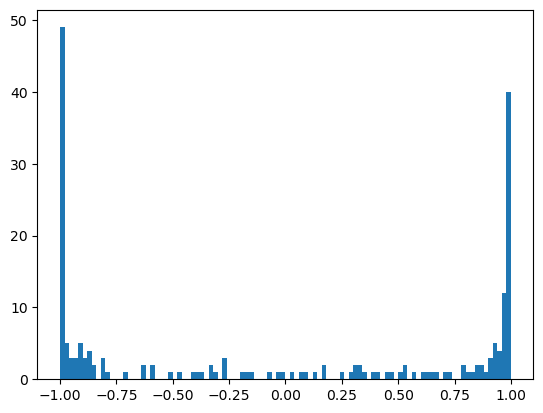

In [6]:
# Forward pass
for epoch in range(epochs):
    # Tune the learning rate and batch size
    if epoch == adjustment_epoch:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')
    elif epoch == epochs-5000:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

    rand_batch_idx = torch.randint(0, num_names, (batch_size,))
    x_batch = X[rand_batch_idx]
    y_batch = Y[rand_batch_idx]

    # Embed the characters
    emb = C[x_batch]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    h = torch.tanh(hpreact)

    # Print the distribution of the first hidden layer
    plt.hist(h[0].detach().numpy(), bins=100)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, y_batch)
    loss_counts.append(loss.item())
    
    # Backward pass
    loss.backward()
    
    # Update the weights
    with torch.no_grad():
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad
        C -= lr * C.grad
        
    # Zero the gradients
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    C.grad.zero_()

    break   # TODO: Remove this line to train the model

weights = [C, W1, b1, W2, b2]
# print(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}, K={K}, neurons={neurons}, block_size={block_size}, epochs={epochs}')



#### Learnings from a saturated tanh activation function

Ok this graph above shows the distributions for the activations from our first hidden layer.  Since the tanh squeezes input between -1 and 1, we have so much of our input there it's problematic because the derivative of tanh(-1) and tanh(1) are zero.  Which means that when we backpack prop through this, our gradients will not be updating since there's no derivative to go off of.  

The above graph just calculates this for the first example, let's extend this to all examples in our batch (at least for the first epoch)

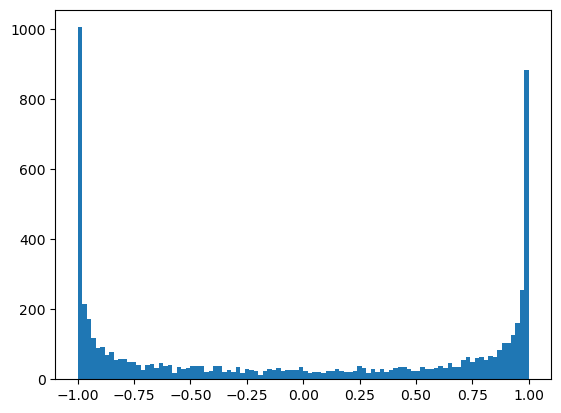

In [7]:
h_values = h.view(-1).tolist()
plt.hist(h_values, bins=100);   # wow this semi-colon supresses the print statement from plt.hist :)

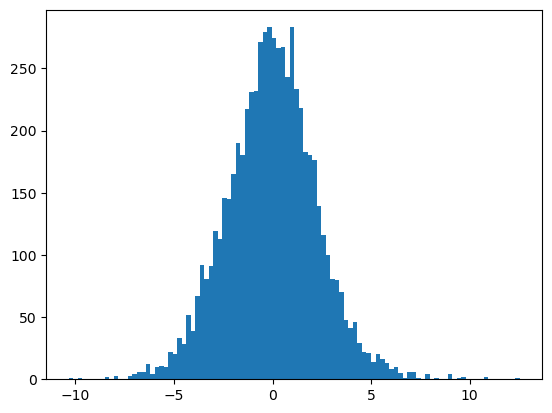

In [8]:
# Let's view the distribution of the first hidden layer pre-activation
hpreact_values = hpreact.view(-1).tolist()
plt.hist(hpreact_values, bins=100);

Note that anything less than -1 or greater than 1 gets squashed hard by the tail end of the tanh function.  So our hidden layer pre-activation distribution above is showing us that these values are way too broad.  Let's learn a bit more about just how extreme our activated tanh values are..

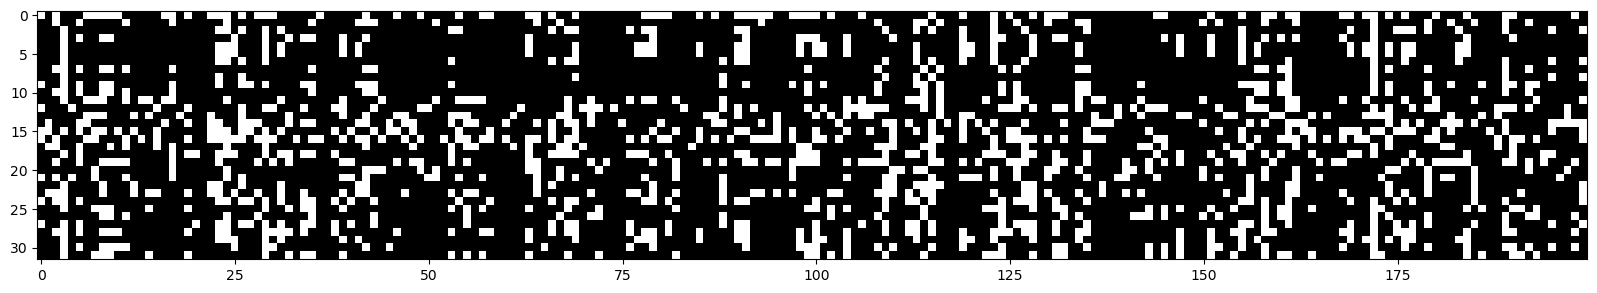

In [9]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, interpolation='nearest', cmap='gray')

Where the values are extreme (>.99) it will be painted white.  aka white pixel = bad.  If for any column here (or neuron), it was all white, it would indicate that for any example inputted to that neuron, all the values are squashed so much that the backprop won't work and that neuron is essentially a 'dead neuron'.  No example is activated in the 'active' part of the tanh.  Therefore this neuron never learns.  A nueron that's always spitting out -1 or 1 sucks because all the gradients on the way back essentially get zeroed out. 

We want neurons that update more frequently/train.  If hpreact was closer to zero, then the tanh activation tanh(~0) would be able to learn a lot more.  So let's squash the initial weights even more and see how the neuron activations changes from the picture above

In [10]:
# construct the first hidden layer
W1 = torch.randn(layer_size, neurons)   * 0.3
b1 = torch.randn(neurons)               * 0.1

# construct the output layer
W2 = torch.randn(neurons, 27)
W2 = W2 * 0.01  # Initialize the weights to be small for a good starting point (prevent false overconfidence)
b2 = torch.randn(27) * 0

# Set the parameters to require gradients
parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True

# Forward pass
for epoch in range(epochs):
    # Tune the learning rate and batch size
    if epoch == adjustment_epoch:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')
    elif epoch == epochs-5000:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

    rand_batch_idx = torch.randint(0, num_names, (batch_size,))
    x_batch = X[rand_batch_idx]
    y_batch = Y[rand_batch_idx]

    # Embed the characters
    emb = C[x_batch]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    h = torch.tanh(hpreact)

    # Print the distribution of the first hidden layer
    # plt.hist(h[0].detach().numpy(), bins=100)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, y_batch)
    loss_counts.append(loss.item())
    
    # Backward pass
    loss.backward()
    
    # Update the weights
    with torch.no_grad():
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad
        C -= lr * C.grad
        
    # Zero the gradients
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    C.grad.zero_()

    break   # TODO: Remove this line to train the model

weights = [C, W1, b1, W2, b2]
# print(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}, K={K}, neurons={neurons}, block_size={block_size}, epochs={epochs}')

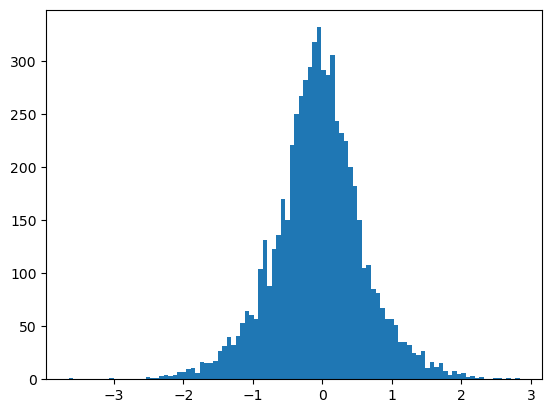

In [11]:
hpreact_values = hpreact.view(-1).tolist()
plt.hist(hpreact_values, bins=100);

This is a huge difference than the hpreact above before we didn't scale down W1, b1.  We went from a range of -10:10 to -1:1.  Let's see how this affected our activations

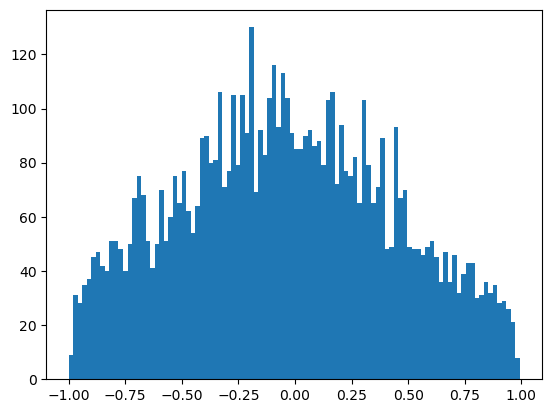

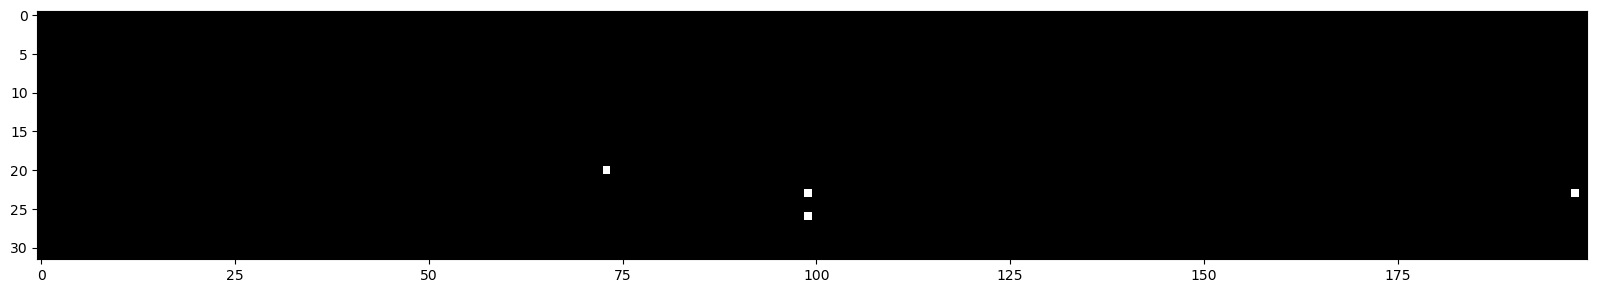

In [12]:
h_values = h.view(-1).tolist()
plt.hist(h_values, bins=100);   # wow this semi-colon supresses the print statement from plt.hist :)
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, interpolation='nearest', cmap='gray')



Holy crap, this is almost black.  Which means we have hardly any dead neurons anymore.  Every neuron is getting activated now and should be able to learn in backprop


- We don't want hpreact to be too small because then tanh does not do anything, and we don't want them to be too large because then tanh becomes saturated.  Hmm I understand the latter as we've just demonstrated that, but what happens when hpreact is super small?  Let's do a quick experiment and find out

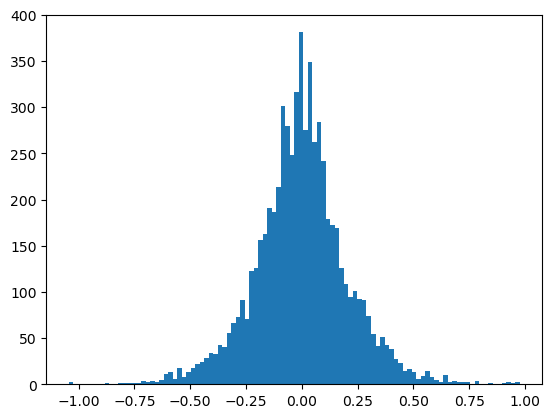

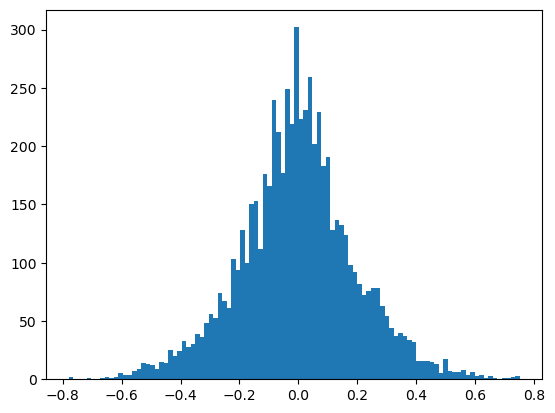

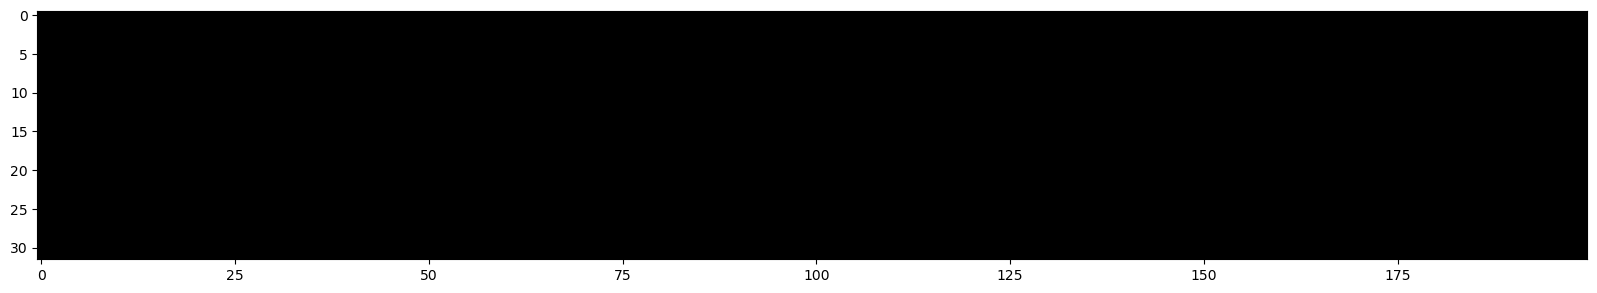

In [13]:
# construct the first hidden layer
W1 = torch.randn(layer_size, neurons)   * 0.1
b1 = torch.randn(neurons)               * 0.01

# construct the output layer
W2 = torch.randn(neurons, 27)
W2 = W2 * 0.01  # Initialize the weights to be small for a good starting point (prevent false overconfidence)
b2 = torch.randn(27) * 0

# Set the parameters to require gradients
parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True

# Forward pass
for epoch in range(epochs):
    # Tune the learning rate and batch size
    if epoch == adjustment_epoch:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')
    elif epoch == epochs-5000:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

    rand_batch_idx = torch.randint(0, num_names, (batch_size,))
    x_batch = X[rand_batch_idx]
    y_batch = Y[rand_batch_idx]

    # Embed the characters
    emb = C[x_batch]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    h = torch.tanh(hpreact)

    # Print the distribution of the first hidden layer
    # plt.hist(h[0].detach().numpy(), bins=100)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, y_batch)
    loss_counts.append(loss.item())
    
    # Backward pass
    loss.backward()
    
    # Update the weights
    with torch.no_grad():
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad
        C -= lr * C.grad
        
    # Zero the gradients
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    C.grad.zero_()

    break   # TODO: Remove this line to train the model

weights = [C, W1, b1, W2, b2]
# print(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}, K={K}, neurons={neurons}, block_size={block_size}, epochs={epochs}')


plt.hist(hpreact.view(-1).tolist(), bins=100);
plt.show()

plt.hist(h.view(-1).tolist(), bins=100);   # wow this semi-colon supresses the print statement from plt.hist :)
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, interpolation='nearest', cmap='gray')

![tanh](images/tanh.png)

Ah I've figured it out, if we examine the tanh function between -1:1 it is almost a line. so basically a passthru linear function, so it doesn't do much with the input. Input ~= Output

The smaller the input, the less the tanh is doing, but at the same time we don't want them to be too large.  So we don't want the values to be close to zero and we dont' want large values that are saturated and are getting overly squashed.  We want our input to tanh to be roughly gaussian, so zero mean and one standard deviation, at least at initialization

### Batch Normalization
- We have hidden states, want them to be roughly gaussian, so why not take the hidden states and normalize them to be roughly gaussian

![batch norm](images/batch-norm.png)

- So we're going to subtract our input from the mean and then divide by the standard deviation to normalize our batch

#### Normalization

In [14]:
hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

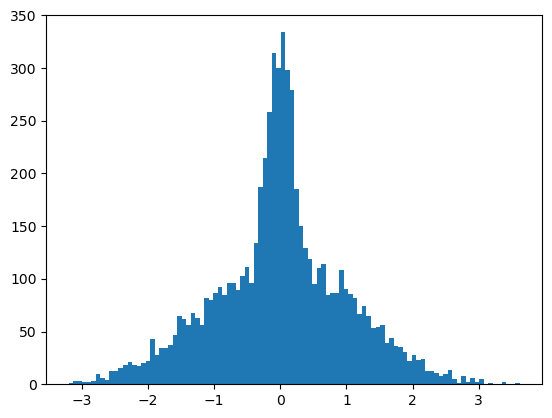

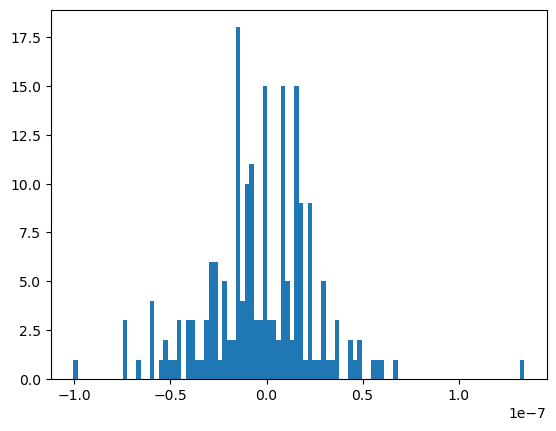

In [15]:
plt.hist(hpreact.view(-1).tolist(), bins=100);
plt.show()
plt.hist(hpreact.mean(0, keepdim=True).view(-1).tolist(), bins=100);
plt.show()

#### Scale and Shift 

- Now we want our hpreact to be roughly unit guassian at initialization but not necessarily throughout the training of our network.  We want to let the gradients shift our distributions as needed and let tanh activate where it needs to, and let it passthrough otherwise.  
- To implement this, we are going to do a 'shift and scale' as show in the image above and introduce a gain and bias
- `bngain` and `bnbias` are the scale and shift parameters for batch normalization.
- `hpreactNorm` is normalized for a gaussian distribution
- At initialization, `bngain` and `bnbias` are set to 1 and zero respectively as to preserve a unit guassian distribution (aka leave `hpreactNorm` alone).  However during training, these parameters are updated so that the distribution can be changed by the NN from a gaussian to whatever the NN needs

$$ hpreact = emb @ W1 + b1 $$
$$ hpreactNorm = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) $$
$$ hpreact = bngain * hpreactNorm + bnbias $$

    

In [16]:
# construct the first hidden layer
W1 = torch.randn(layer_size, neurons)   * 0.1
b1 = torch.randn(neurons)               * 0.01

# construct the output layer
W2 = torch.randn(neurons, 27)
W2 = W2 * 0.01  # Initialize the weights to be small for a good starting point (prevent false overconfidence)
b2 = torch.randn(27) * 0

# Batch normalization Scale and shift
# These values are initialized to 1 and 0 respectively to keep a guassian distribution
bngain = torch.ones((1, neurons))
bnbias = torch.zeros((1, neurons))

# Set the parameters to require gradients
parameters = [W1, b1, W2, b2, C, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

# Forward pass
for epoch in range(epochs):
    # Tune the learning rate and batch size
    if epoch == adjustment_epoch:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

    rand_batch_idx = torch.randint(0, num_names, (batch_size,))
    x_batch = X[rand_batch_idx]
    y_batch = Y[rand_batch_idx]

    # Embed the characters
    emb = C[x_batch]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, y_batch)
    loss_counts.append(loss.item())
    
    # Backward pass
    loss.backward()

    # Update the weights
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    # Zero the gradients
    for p in parameters:
        p.grad.zero_()

Adjusting learning rate to 0.01, batch_size=320


Text(0.5, 1.0, 'Loss over time')

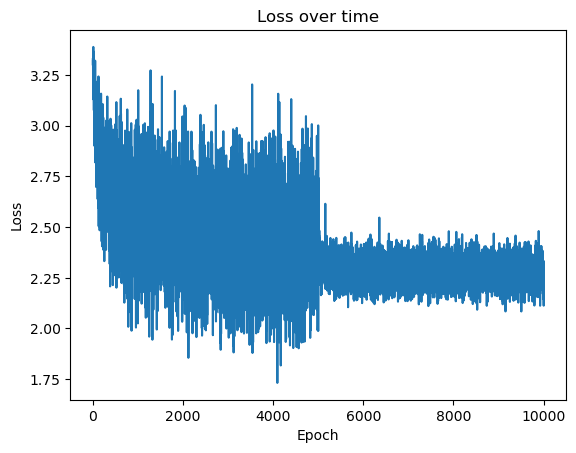

In [17]:
# Plot the loss
plt.plot(loss_counts)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss over time')
# plt.annotate(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')


Adjusting learning rate to 0.01, batch_size=320


(2.797611951828003, 2.8012478351593018)

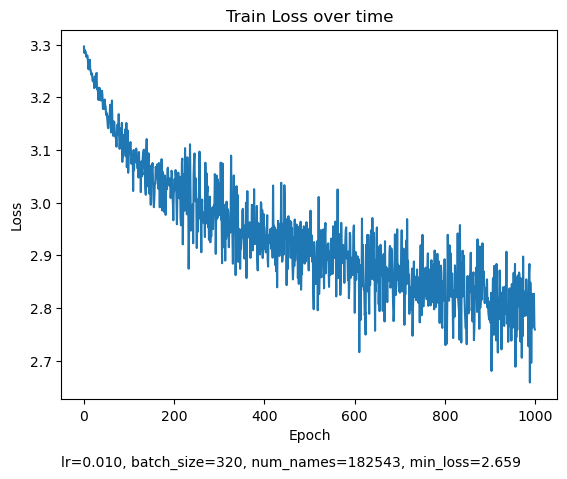

In [18]:
# train the model
def train_model(x, y, plot=True):
    hyperparams = {
        'epochs':1000,
        'K': 3,
        'neurons': 200,
        'block_size': 3,
        'lr': 0.1,
        'batch_size': 32,
    }

    # Unpack the hyperparameters from the dictionary
    K = hyperparams['K']
    neurons = hyperparams['neurons']
    block_size = hyperparams['block_size']
    epochs = hyperparams['epochs']
    lr = hyperparams['lr']
    batch_size = hyperparams['batch_size']

    adjustment_epoch = epochs - 1000
    layer_size = K * block_size
    loss_counts = []

    # Embed the characters
    C = torch.randn((27, K))

    # construct the first hidden layer
    W1 = torch.randn(layer_size, neurons)   * 0.1
    b1 = torch.randn(neurons)               * 0.01

    # construct the output layer
    W2 = torch.randn(neurons, 27)
    W2 = W2 * 0.01  # Initialize the weights to be small for a good starting point (prevent false overconfidence)
    b2 = torch.randn(27) * 0

    # Batch normalization Scale and shift
    # These values are initialized to 1 and 0 respectively to keep a guassian distribution
    bngain = torch.ones((1, neurons))
    bnbias = torch.zeros((1, neurons))

    # Set the parameters to require gradients
    parameters = [W1, b1, W2, b2, C, bngain, bnbias]

    num_names = x.shape[0]

    for p in parameters:
        p.requires_grad = True

    # Forward pass
    for epoch in range(epochs):
        # Tune the learning rate and batch size
        if epoch == adjustment_epoch:
            lr = lr / 10
            batch_size = batch_size * 10
            print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

        rand_batch_idx = torch.randint(0, num_names, (batch_size,))
        x_batch = x[rand_batch_idx]
        y_batch = y[rand_batch_idx]

        # Embed the characters
        emb = C[x_batch]
        emb = emb.view(-1, layer_size)

        # Calculate the first hidden layer
        hpreact = emb @ W1 + b1
        hpreact_norm = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # normalize
        hpreact = bngain * hpreact_norm + bnbias                                                # scale and shift
        h = torch.tanh(hpreact)

        logits = h @ W2 + b2

        # Calculate the loss
        loss = F.cross_entropy(logits, y_batch)
        loss_counts.append(loss.item())
        
        # Backward pass
        loss.backward()

        # Update the weights
        with torch.no_grad():
            for p in parameters:
                p -= lr * p.grad
            
        # Zero the gradients
        for p in parameters:
            p.grad.zero_()

    if plot:
        # Plot the loss
        plt.plot(loss_counts)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Train Loss over time')
        plt.annotate(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
    
    return C, W1, b1, W2, b2, bngain, bnbias

# evaluate the training and validation loss
def evaluate_loss(X, Y):
    # Embed the characters
    emb = C[X]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, Y)
    return loss.item()

def get_input_output(names):
    # Create a dictionary of characters and their indices
    chars = sorted(list(set(''.join(names))))
    char2idx = {c: i+1 for i, c in enumerate(chars)}
    idx2char = {i+1: c for i, c in enumerate(chars)}
    char2idx['.'] = 0
    idx2char[0] = '.'

    # Build the dataset
    X, Y = [], []

    for name in names:
        name = name + '.'
        context = [0] * block_size      # The first context is a block of zeros which enables padding
        for c in name:
            X.append(context)
            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return X, Y
        
x_train, y_train = get_input_output(train_names)
x_val, y_val = get_input_output(val_names)

# train the model
C, W1, b1, W2, b2, bngain, bnbias = train_model(x_train, y_train)

train_loss = evaluate_loss(x_train, y_train)
val_loss = evaluate_loss(x_val, y_val)

train_loss, val_loss

The following

```
    hyperparams = {
        'epochs':100000,
        'K': 3,
        'neurons': 200,
        'block_size': 3,
        'lr': 0.1,
        'batch_size': 32,
    }
```

helped me to achieve a training and validation loss of (2.1659, 2.1873).  all time high :)

An interesting point Andrej makes about batch normalization is that if we look at 

$$ hpreact = emb @ W1 + b1 $$
$$ hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias $$
$$ h = torch.tanh(hpreact) $$

It's kind of weird that `h` is being influenced by the distribution of our input, which in this case is a batch.  The hidden layer activation is actually being influenced by the other input examples included in our batch.  However, in practice this weird property gives `h` some jitter and the noise actually acts as a regularizer that prevents the NN from overfitting

In the training, we are normalizing batches, but what happens when we want to evaluate our model on a single example and there isn't a batch to normalize on?  One way is after training, calculate the mean/std of the entire training set, and then used this to normalize `hpreact`.  But hmm, when we have one example, why are we trying to fit it to a distribution?  I guess because we still want it to activate properly (not too low or saturated).  

In [19]:
# calculate the batch normalization at the end of training
with torch.no_grad():           # don't track gradients for the operations below (saves memory)
    # pass the training data through the network
    emb = C[x_train]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bmean = hpreact.mean(0, keepdim=True)
    bstd = hpreact.std(0, keepdim=True)
    
# evaluate the training and validation loss
def evaluate_loss(X, Y):
    # Embed the characters
    emb = C[X]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    hpreact = bngain * (hpreact - bmean) / bstd + bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, Y)
    
    return loss.item()

Andrej then shows how we can calculate bmean/bstd during training so that we dont have to compute it as a standalone operation afterwards.  Going to avoid doing that here but useful to know as to reduce unnecessary computation.

We're using batch normalization to control the statistics of our activations for any linear layers we have in our network (i.e. w * x) and later for even convolutions.  It's common to sprinkle batch norm across our neural net wherever linear layers are being activated.   Usually batch norm is placed after layers that are multiplied (linear w*x or convolutions)

### Pytorch-ify the code
- Let's break our code into modules so it's easier to construct our networks

In [20]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # Kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    
class BatchNorm1d:
    def __init__(self, fan_in, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True        # unsure how this can be set to False ??
        self.gamma = torch.ones(fan_in)
        self.beta = torch.zeros(fan_in)
        self.running_mean =  torch.zeros(fan_in)
        self.running_var = torch.ones(fan_in)
        
    def __call__(self, x):
        if self.training:        # how to set this to False ?? 
            mean = x.mean(0, keepdim=True)
            var = x.var(0, keepdim=True)
        else:
            mean = self.running_mean
            var = self.running_var
        x = (x - mean) / (var + self.eps)**0.5  # normalize
        self.out = x * self.gamma + self.beta   # scale and shift
        if self.training:
            with torch.no_grad():
                # update the running mean and variance using exponential moving average
                self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [21]:
K = 3                                           # character embedding size
block_size = 3                                  # context size        
neurons = 100
vocab_size = 27
layer_size = K * block_size
C = torch.randn((vocab_size, K))

layers = [
    Linear(layer_size, neurons),                Tanh(),
    Linear(neurons, neurons),                   Tanh(),
    Linear(neurons, neurons),                   Tanh(),
    Linear(neurons, neurons),                   Tanh(),
    Linear(neurons, neurons),                   Tanh(),
    Linear(neurons, neurons),                   Tanh(),
    Linear(neurons, vocab_size)
]

with torch.no_grad():
    # make last layer less sensitive to the initial weights
    layers[-1].weight *= 0.01
    # for all other layers apply gain and scale to counteract the squashing effect of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total number of parameters:", sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True


Total number of parameters: 54308


0: 3.295


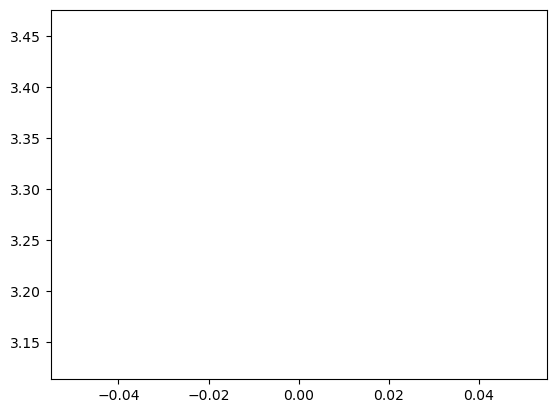

In [22]:
# gradient descent
epochs = 1000
batch_size = 32
loss_counts = []
lr = 0.1

for i in range(epochs):
    # get the batch
    ix = torch.randint(0, x_train.shape[0], (batch_size,))
    X = x_train[ix]
    Y = y_train[ix]

    # forward pass
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)        # move the input through each layer in the network
    # calculate the loss
    loss = F.cross_entropy(x, Y)
    loss_counts.append(loss.item())

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    loss.backward()

    # update the parameters
    with torch.no_grad():
        if i == int(epochs * 0.75):     # reduce the learning rate after 75% of the epochs
            lr = 0.01

        for p in parameters:
            p -= p.grad * lr
            p.grad.zero_()

    if i % 100 == 0:
        print(f"{i}: {loss.item():.3f}")

    break

# plot the loss
plt.plot(loss_counts)
plt.show()

layer 1 (Tanh): mean=0.016, std=0.781, saturations=0.200
layer 3 (Tanh): mean=0.002, std=0.703, saturations=0.092
layer 5 (Tanh): mean=0.008, std=0.671, saturations=0.051
layer 7 (Tanh): mean=0.021, std=0.656, saturations=0.037
layer 9 (Tanh): mean=-0.017, std=0.664, saturations=0.036
layer 11 (Tanh): mean=0.011, std=0.663, saturations=0.055


Text(0.5, 1.0, 'Activation distributions')

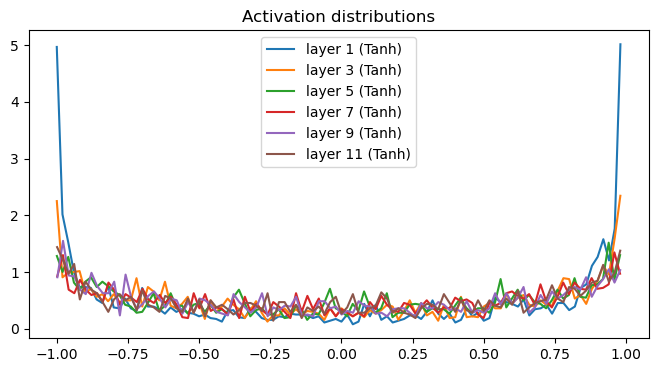

In [23]:
# visualize histograms of the activation distributions

plt.figure(figsize=(8, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}): mean={t.mean():.3f}, std={t.std():.3f}, saturations={((t.abs() > 0.98).sum() / t.numel()):.3f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distributions')

layer 1 (Tanh): mean=-0.000, std=0.000
layer 3 (Tanh): mean=0.000, std=0.000
layer 5 (Tanh): mean=0.000, std=0.000
layer 7 (Tanh): mean=-0.000, std=0.000
layer 9 (Tanh): mean=0.000, std=0.000
layer 11 (Tanh): mean=-0.000, std=0.000


Text(0.5, 1.0, 'Gradient distributions')

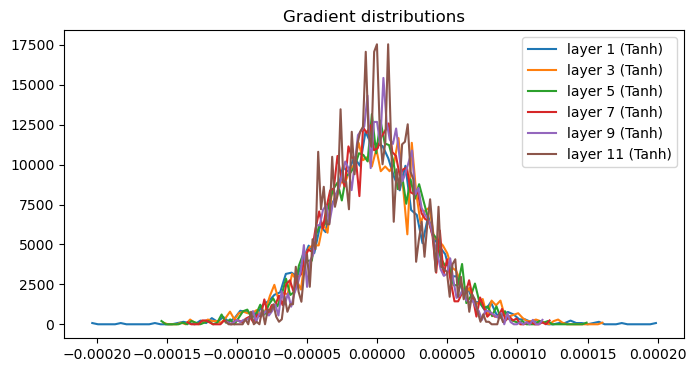

In [24]:
# Let's also visualize the distribution of the gradients
plt.figure(figsize=(8, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}): mean={t.mean():.3f}, std={t.std():.3f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distributions')

The gain we apply to our linear layers has to balance a tradeoff in the activation output (which we don't want going to zero) and the gradients (which we also don't want going to zero).  We want to counter the squashing of the tanh without saturating the activations to -1 and 1.  $5/3$ happens to be a good gain value to accomplish this.

$$ layer.weight = layer.weight * 5/3 $$

What would happen if we didn't have any tanh layers?  Then we would have no non-linearities and all of our linear layers could essentially be squashed down to just one linear layer, let's take a look and try that out..

In [25]:
K = 3                                           # character embedding size
block_size = 3                                  # context size
neurons = 100
vocab_size = 27
layer_size = K * block_size
C = torch.randn((vocab_size, K))

layers = [
    Linear(layer_size, neurons),                
    Linear(neurons, neurons),                                  
    Linear(neurons, neurons),                                  
    Linear(neurons, vocab_size)
]

with torch.no_grad():
    # make last layer less sensitive to the initial weights
    layers[-1].weight *= 0.01
    # for all other layers apply gain and scale to counteract the squashing effect of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total number of parameters:", sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True


Total number of parameters: 24008


0: 3.296


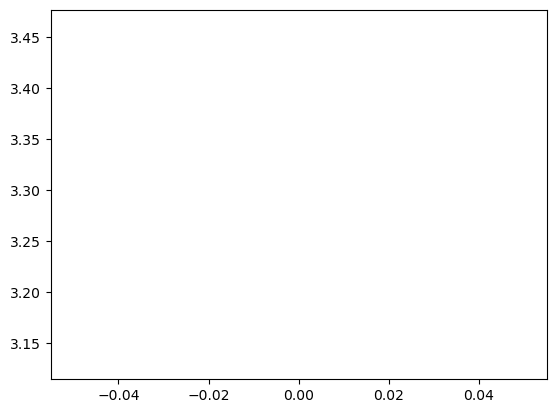

In [26]:
# gradient descent
epochs = 1000
batch_size = 32
loss_counts = []
lr = 0.1

for i in range(epochs):
    # get the batch
    ix = torch.randint(0, x_train.shape[0], (batch_size,))
    X = x_train[ix]
    Y = y_train[ix]

    # forward pass
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)        # move the input through each layer in the network
    # calculate the loss
    loss = F.cross_entropy(x, Y)
    loss_counts.append(loss.item())

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    loss.backward()

    # update the parameters
    with torch.no_grad():
        if i == int(epochs * 0.75):     # reduce the learning rate after 75% of the epochs
            lr = 0.01

        for p in parameters:
            p -= p.grad * lr
            p.grad.zero_()

    if i % 100 == 0:
        print(f"{i}: {loss.item():.3f}")

    break

# plot the loss
plt.plot(loss_counts)
plt.show()

layer 0 (Linear): mean=-0.008, std=0.831, saturations=0.205
layer 1 (Linear): mean=0.038, std=0.860, saturations=0.232
layer 2 (Linear): mean=-0.031, std=0.885, saturations=0.237


Text(0.5, 1.0, 'Activation distributions')

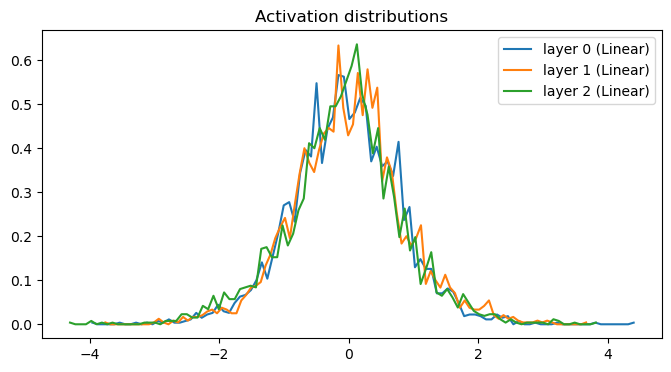

In [27]:
# visualize histograms of the activation distributions

plt.figure(figsize=(8, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}): mean={t.mean():.3f}, std={t.std():.3f}, saturations={((t.abs() > 0.98).sum() / t.numel()):.3f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distributions')

Hmm at first I was confused why values weren't being squashed to -1 and 1 and then I remembered we've removed the tanh function :)  But looking at the layers, it all looks like a pretty descent normal distribution with a mean of 0 and a std of 1.  Let's examine the gradients

layer 0 (Linear): mean=-0.000, std=0.000
layer 1 (Linear): mean=0.000, std=0.000
layer 2 (Linear): mean=0.000, std=0.000


Text(0.5, 1.0, 'Gradient distributions')

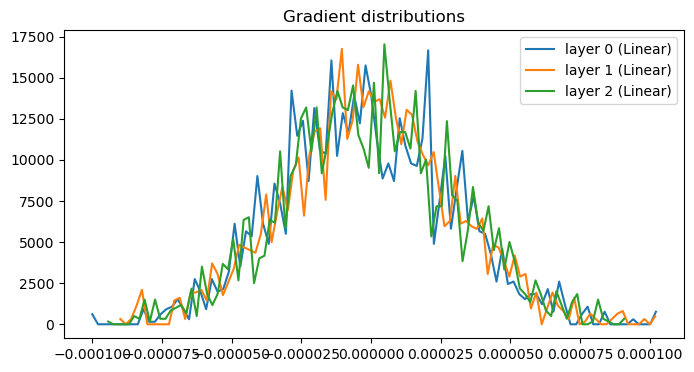

In [28]:
# Let's also visualize the distribution of the gradients
plt.figure(figsize=(8, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}): mean={t.mean():.3f}, std={t.std():.3f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distributions')

the gradients look a bit too small here.  

##### Gradient stats in comparison to data 
- Let's compare the gradients to the out data.  aka let's see how big of a change we're making in relation to what we have

In [29]:
K = 3                                           # character embedding size
block_size = 3                                  # context size        
neurons = 100
vocab_size = 27
layer_size = K * block_size
C = torch.randn((vocab_size, K))

layers = [
    Linear(layer_size, neurons),                Tanh(),
    Linear(neurons, neurons),                   Tanh(),
    Linear(neurons, neurons),                   Tanh(),
    Linear(neurons, neurons),                   Tanh(),
    Linear(neurons, neurons),                   Tanh(),
    Linear(neurons, neurons),                   Tanh(),
    Linear(neurons, vocab_size)
]

with torch.no_grad():
    # make last layer less sensitive to the initial weights
    layers[-1].weight *= 0.01
    # for all other layers apply gain and scale to counteract the squashing effect of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total number of parameters:", sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True


Total number of parameters: 54308


udvalue: -2.0299906730651855
0: 3.296
udvalue: -1.6656256914138794
udvalue: -1.650188684463501
udvalue: -1.6776643991470337
udvalue: -1.7933803796768188
udvalue: -1.714645266532898
udvalue: -1.6596301794052124
udvalue: -1.739756464958191
udvalue: -1.8845901489257812
udvalue: -1.9813625812530518
udvalue: -1.768579125404358
udvalue: -1.857828140258789
udvalue: -1.9552245140075684
udvalue: -1.7450063228607178
udvalue: -1.8601927757263184
udvalue: -1.9693654775619507
udvalue: -1.8196110725402832
udvalue: -1.8627480268478394
udvalue: -1.8872947692871094
udvalue: -1.7604422569274902
udvalue: -1.8006763458251953
udvalue: -1.8307722806930542
udvalue: -1.8911734819412231
udvalue: -1.804339051246643
udvalue: -1.9643781185150146
udvalue: -1.8072105646133423
udvalue: -1.9673823118209839
udvalue: -2.014543294906616
udvalue: -1.9142526388168335
udvalue: -2.1122324466705322
udvalue: -1.9465144872665405
udvalue: -2.0239901542663574
udvalue: -1.9588340520858765
udvalue: -2.055534839630127
udvalue: -2.0

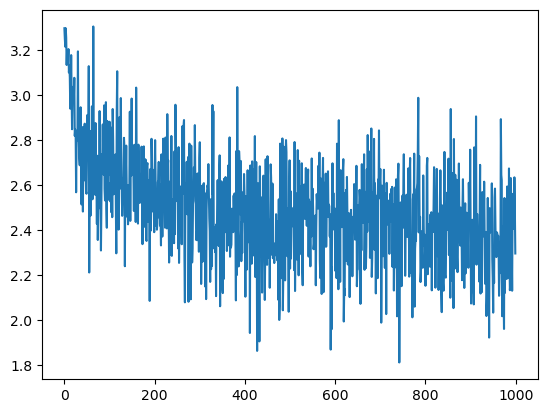

In [30]:
# gradient descent
epochs = 1000
batch_size = 32
loss_counts = []
lr = 0.1
ud = [] # update distribution

for i in range(epochs):
    # get the batch
    ix = torch.randint(0, x_train.shape[0], (batch_size,))
    X = x_train[ix]
    Y = y_train[ix]

    # forward pass
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)        # move the input through each layer in the network
    # calculate the loss
    loss = F.cross_entropy(x, Y)
    loss_counts.append(loss.item())

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    if i == int(epochs * 0.75):     # reduce the learning rate after 75% of the epochs
        lr = 0.01
    for p in parameters:
        p.data -= p.grad * lr

    with torch.no_grad():
        udvalue = [((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]   # update:data ratio
        print(f'udvalue: {(torch.tensor(udvalue).mean())}')
        ud.append(udvalue)

    if i % 100 == 0:
        print(f"{i}: {loss.item():.3f}")

    # break

# plot the loss
plt.plot(loss_counts)
plt.show()

layer 1 (Tanh): mean=-0.030, std=0.761, saturations=0.189
layer 3 (Tanh): mean=0.033, std=0.717, saturations=0.097
layer 5 (Tanh): mean=-0.032, std=0.713, saturations=0.073
layer 7 (Tanh): mean=-0.007, std=0.718, saturations=0.078
layer 9 (Tanh): mean=0.012, std=0.728, saturations=0.091
layer 11 (Tanh): mean=-0.001, std=0.692, saturations=0.064


Text(0.5, 1.0, 'Activation distributions')

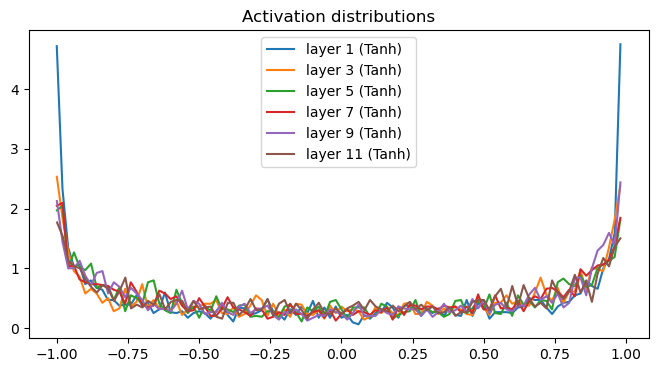

In [31]:
# visualize histograms of the activation distributions

plt.figure(figsize=(8, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}): mean={t.mean():.3f}, std={t.std():.3f}, saturations={((t.abs() > 0.98).sum() / t.numel()):.3f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distributions')

layer 1 (Tanh): mean=-0.000, std=0.003
layer 3 (Tanh): mean=0.000, std=0.003
layer 5 (Tanh): mean=-0.000, std=0.003
layer 7 (Tanh): mean=0.000, std=0.003
layer 9 (Tanh): mean=0.000, std=0.002
layer 11 (Tanh): mean=0.000, std=0.002


Text(0.5, 1.0, 'Gradient distributions')

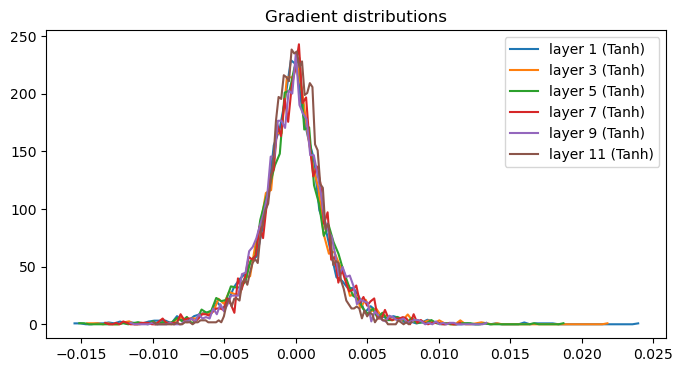

In [32]:
# Let's also visualize the distribution of the gradients
plt.figure(figsize=(8, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}): mean={t.mean():.3f}, std={t.std():.3f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distributions')

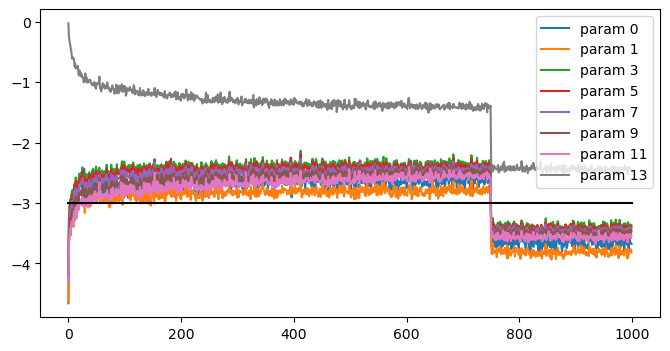

In [33]:


# Visualize the update ratio of the parameters
plt.figure(figsize=(8, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

- If below -3, then our parameters aren't learning fast enough
- Ideally, our LR is around -3 (where the horizontal black line is)

### Re-introduce batch norm in our network

In [34]:
K = 3                                           # character embedding size
block_size = 3                                  # context size        
neurons = 100
vocab_size = 27
layer_size = K * block_size
C = torch.randn((vocab_size, K))

layers = [
    Linear(layer_size, neurons),    BatchNorm1d(neurons),        Tanh(),
    Linear(neurons, neurons),       BatchNorm1d(neurons),        Tanh(),
    Linear(neurons, neurons),       BatchNorm1d(neurons),        Tanh(),
    Linear(neurons, neurons),       BatchNorm1d(neurons),        Tanh(),
    Linear(neurons, neurons),       BatchNorm1d(neurons),        Tanh(),
    Linear(neurons, neurons),       BatchNorm1d(neurons),        Tanh(),
    Linear(neurons, vocab_size),    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # make last layer less sensitive to the initial weights
    layers[-1].gamma *= 0.01
    # for all other layers apply gain and scale to counteract the squashing effect of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total number of parameters:", sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True


Total number of parameters: 55562


0: 3.295
100: 2.908
200: 2.740
300: 2.709
400: 2.863
500: 2.643
600: 2.571
700: 2.668
800: 2.813
900: 2.725


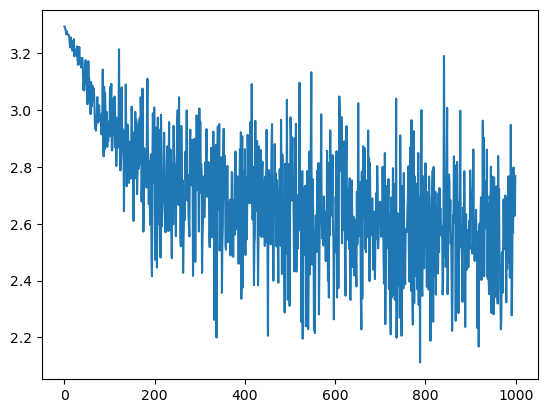

In [35]:
# gradient descent
epochs = 1000
batch_size = 32
loss_counts = []
lr = 0.1
ud = [] # update distribution

for i in range(epochs):
    # get the batch
    ix = torch.randint(0, x_train.shape[0], (batch_size,))
    X = x_train[ix]
    Y = y_train[ix]

    # forward pass
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)        # move the input through each layer in the network
    # calculate the loss
    loss = F.cross_entropy(x, Y)
    loss_counts.append(loss.item())

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    if i == int(epochs * 0.75):     # reduce the learning rate after 75% of the epochs
        lr = 0.01
    for p in parameters:
        p.data -= p.grad * lr

    with torch.no_grad():
        udvalue = [((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]   # update:data ratio
        # print(f'udvalue: {(torch.tensor(udvalue).mean())}')
        ud.append(udvalue)

    if i % 100 == 0:
        print(f"{i}: {loss.item():.3f}")

    # break

# plot the loss
plt.plot(loss_counts)
plt.show()

layer 2 (Tanh): mean=0.001, std=0.631, saturations=0.022
layer 5 (Tanh): mean=-0.002, std=0.637, saturations=0.014
layer 8 (Tanh): mean=0.003, std=0.646, saturations=0.010
layer 11 (Tanh): mean=-0.002, std=0.649, saturations=0.009
layer 14 (Tanh): mean=-0.006, std=0.650, saturations=0.006
layer 17 (Tanh): mean=-0.001, std=0.652, saturations=0.007


Text(0.5, 1.0, 'Activation distributions')

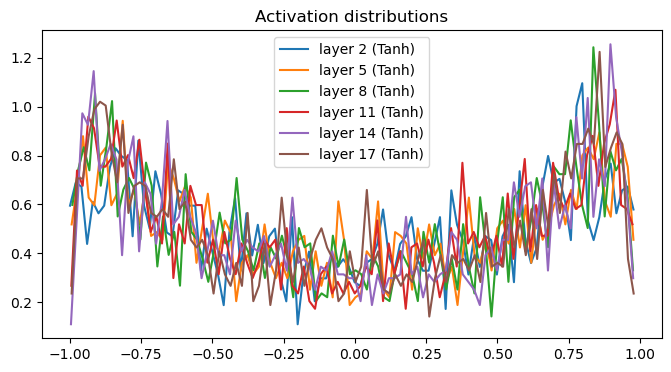

In [36]:
# visualize histograms of the activation distributions

plt.figure(figsize=(8, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}): mean={t.mean():.3f}, std={t.std():.3f}, saturations={((t.abs() > 0.98).sum() / t.numel()):.3f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distributions')

Wow the batch norm makes this chart look great

layer 2 (Tanh): mean=-0.000, std=0.003
layer 5 (Tanh): mean=0.000, std=0.002
layer 8 (Tanh): mean=-0.000, std=0.002
layer 11 (Tanh): mean=0.000, std=0.002
layer 14 (Tanh): mean=0.000, std=0.002
layer 17 (Tanh): mean=-0.000, std=0.002


Text(0.5, 1.0, 'Gradient distributions')

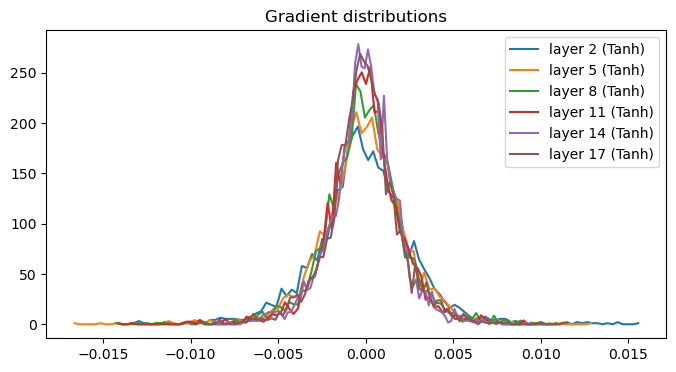

In [37]:
# Let's also visualize the distribution of the gradients
plt.figure(figsize=(8, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}): mean={t.mean():.3f}, std={t.std():.3f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distributions')

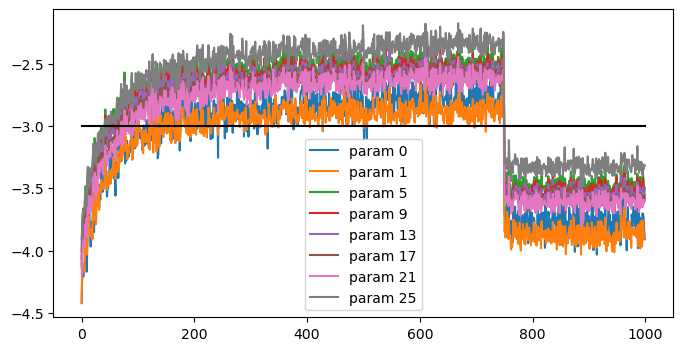

In [38]:


# Visualize the update ratio of the parameters
plt.figure(figsize=(8, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


With the batchnorm layer now added to our network, our network is much less brittle to the gain value but it's still important for the update:data change rate above

#### Exercises:
- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [126]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weight = torch.zeros((fan_in, fan_out)) # initialize with zeros
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    
class BatchNorm1d:
    def __init__(self, fan_in, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True        
        self.gamma = torch.ones(fan_in)
        self.beta = torch.zeros(fan_in)
        self.running_mean =  torch.zeros(fan_in)
        self.running_var = torch.ones(fan_in)
        
    def __call__(self, x):
        if self.training:        
            mean = x.mean(0, keepdim=True)
            var = x.var(0, keepdim=True)
        else:
            mean = self.running_mean
            var = self.running_var
        x = (x - mean) / (var + self.eps)**0.5  # normalize
        self.out = x * self.gamma + self.beta   # scale and shift
        if self.training:
            with torch.no_grad():
                # update the running mean and variance using exponential moving average
                self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [123]:
K = 3                                           # character embedding size
block_size = 3                                  # context size        
neurons = 100
vocab_size = 27
layer_size = K * block_size
C = torch.randn((vocab_size, K))

layers = [
    Linear(layer_size, neurons),#    BatchNorm1d(neurons),        Tanh(),
    # Linear(neurons, neurons),   #    BatchNorm1d(neurons),        Tanh(),
    Linear(neurons, vocab_size),#    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # make last layer less sensitive to the initial weights
    layers[-1].weight *= 0.01
    # for all other layers apply gain and scale to counteract the squashing effect of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total number of parameters:", sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True


Total number of parameters: 3808


0: 3.296
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear: sum is not zero
Linear:

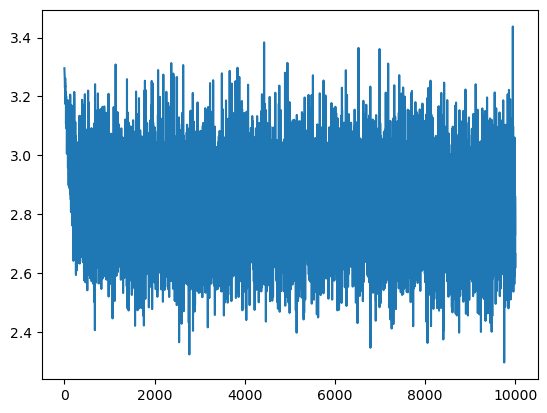

In [121]:
# gradient descent
epochs = 10000
batch_size = 32
loss_counts = []
lr = 0.1
ud = [] # update distribution

for i in range(epochs):
    # get the batch
    # pdb.set_trace()
    ix = torch.randint(0, x_train.shape[0], (batch_size,))
    X = x_train[ix]
    Y = y_train[ix]

    # forward pass
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)        # move the input through each layer in the network
    # calculate the loss
    loss = F.cross_entropy(x, Y)
    loss_counts.append(loss.item())

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    if i == int(epochs * 0.75):     # reduce the learning rate after 75% of the epochs
        lr = 0.01
    for p in parameters:
        p.data -= p.grad * lr

    with torch.no_grad():
        udvalue = [((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]   # update:data ratio
        # if udvalue is inf or nan, replace with 0
        udvalue = [-5 if math.isinf(x) or math.isnan(x) else x for x in udvalue]
        # print(f'udvalue: {(torch.tensor(udvalue).mean())}')
        ud.append(udvalue)

    if i % 100 == 0:
        print(f"{i}: {loss.item():.3f}")

    # break

# plot the loss
plt.plot(loss_counts)
plt.show()

Answer: 
I think what's happening here is that the gradients are flowing back from the softmax of the output layer.  They are extremely small and thus the network's learning rate should be very slow

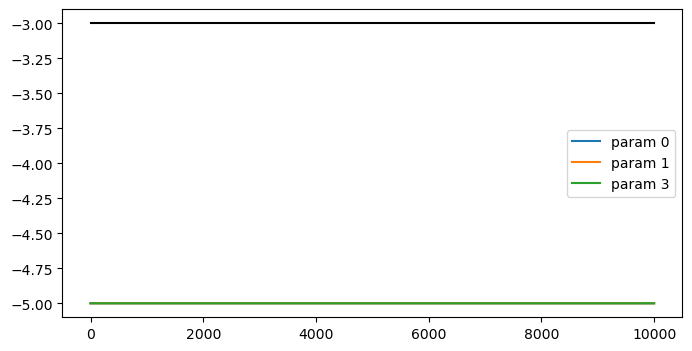

In [103]:


# Visualize the update ratio of the parameters
plt.figure(figsize=(8, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


in the update ratio chart above, I pinned all Nan/Inf values to -5, which shows that pretty much every parameter is not learning. and we can see that the update ratios are so small that our network is effectively not able to learn in any meaningful way

In the picture below, we can see it's the softmax output layer (shape 27) and that there are gradients flowing back, everything up to this point was zeroed out.

![softmax gradients](images/softmax-gradients.png)

#### Re-test with batchnorm and tanh layers
- In the exercise above, I removed the batchnorm and tanh layer for simplicity.  Let's re-add them to our network and see if it changes our outcome

In [127]:
K = 3                                           # character embedding size
block_size = 3                                  # context size        
neurons = 100
vocab_size = 27
layer_size = K * block_size
C = torch.randn((vocab_size, K))

layers = [
    Linear(layer_size, neurons),    BatchNorm1d(neurons),        Tanh(),
    Linear(neurons, neurons),       BatchNorm1d(neurons),        Tanh(),
    Linear(neurons, vocab_size),    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # make last layer less sensitive to the initial weights
    layers[-1].gamma *= 0.01
    # for all other layers apply gain and scale to counteract the squashing effect of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total number of parameters:", sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True


Total number of parameters: 14362


0: 3.296
100: 3.001
200: 3.073
300: 2.702
400: 2.715
500: 3.051
600: 2.831
700: 2.835
800: 3.180
900: 2.823


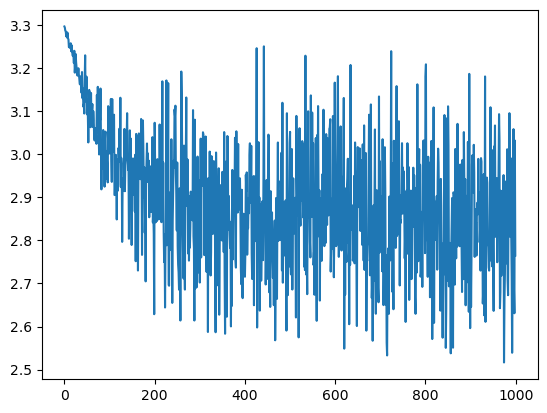

In [128]:
# gradient descent
epochs = 1000
batch_size = 32
loss_counts = []
lr = 0.1
ud = [] # update distribution

for i in range(epochs):
    # get the batch
    ix = torch.randint(0, x_train.shape[0], (batch_size,))
    X = x_train[ix]
    Y = y_train[ix]

    # forward pass
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)        # move the input through each layer in the network
    # calculate the loss
    loss = F.cross_entropy(x, Y)
    loss_counts.append(loss.item())

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    if i == int(epochs * 0.75):     # reduce the learning rate after 75% of the epochs
        lr = 0.01
    for p in parameters:
        if (int(p.grad.sum().item()) != 0):
            print('grad sum is not zero')
        p.data -= p.grad * lr

    with torch.no_grad():
        udvalue = [((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]   # update:data ratio
        # if udvalue is inf or nan, replace with 0
        udvalue = [-5 if math.isinf(x) or math.isnan(x) else x for x in udvalue]
        # print(f'udvalue: {(torch.tensor(udvalue).mean())}')
        ud.append(udvalue)

    if i % 100 == 0:
        print(f"{i}: {loss.item():.3f}")

    # break

# plot the loss
plt.plot(loss_counts)
plt.show()

Ok, so if we zero out the bias from the batchnorm, then the answer remains the same.  We're passing the gradients from the softmax layer back only

### Exercises

- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

Questions:
- BatchNorm vs Kaiming initialization
- When is self.training set to false so that our running mean/std don't get updated at test time